
## **1. Instalación**

In [ ]:
!pip install catboost missingno lazypredict

## **2. Importaciones**

In [ ]:
from joblib import load
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import missingno as msno
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from joblib import dump
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyRegressor


## **3. Abrir Dataset**

In [ ]:
df = load("dataset.csv")

In [ ]:
df.columns

Index(['Date', 'ticker', 'precio_apertura', 'precio_maximo', 'precio_minimo',
       'precio_cierre', 'volumen', 'aluminio_usd', 'petroleo_usd', 'dxy',
       'usd_eur', 'oro_usd', 'cobre_usd', 'gas_natural_usd', 'plata_usd',
       'tasa_tesoro_5y', 'sp500', 'tasa_tesoro_3m', 'tasa_tesoro_10y',
       'volatilidad', 'usd_yen', 'usd_yuan'],
      dtype='object')

In [ ]:
df

,Date,ticker,precio_apertura,precio_maximo,precio_minimo,precio_cierre,volumen,aluminio_usd,petroleo_usd,dxy,...,cobre_usd,gas_natural_usd,plata_usd,tasa_tesoro_5y,sp500,tasa_tesoro_3m,tasa_tesoro_10y,volatilidad,usd_yen,usd_yuan
0,2014-01-03,AAPL,17.15,17.17,16.76,16.78,392467600.00,NaN,93.96,80.79,...,3.41,4.30,20.18,1.73,NaN,0.06,2.99,NaN,0.01,0.17
1,2014-01-06,AAPL,16.67,16.96,16.55,16.87,412610800.00,NaN,93.43,80.65,...,3.41,4.31,20.08,1.70,NaN,0.05,2.96,NaN,0.01,0.17
2,2014-01-07,AAPL,16.88,16.93,16.68,16.75,317209200.00,NaN,93.67,80.83,...,3.41,4.30,19.76,1.67,-0.00,0.04,2.94,-0.02,0.01,0.17
3,2014-01-08,AAPL,16.71,16.92,16.71,16.86,258529600.00,NaN,92.33,81.04,...,3.39,4.22,19.52,1.76,0.01,0.04,2.99,-0.05,0.01,0.17
4,2014-01-09,AAPL,16.96,16.96,16.61,16.64,279148800.00,NaN,91.66,81.01,...,3.35,4.01,19.66,1.75,-0.00,0.03,2.96,-0.00,0.01,0.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61634,2025-12-23,XOM,118.47,120.03,118.32,119.42,12567600.00,2857.50,58.38,97.94,...,5.48,4.41,70.49,3.73,0.01,3.55,4.17,-0.06,0.01,0.14
61635,2025-12-24,XOM,119.33,120.05,119.12,119.22,6137400.00,2865.75,58.35,97.98,...,5.50,4.24,71.03,3.72,0.00,3.56,4.14,-0.01,0.01,0.14
61636,2025-12-26,XOM,118.89,119.55,118.53,119.11,8066100.00,2924.75,56.74,98.02,...,5.77,4.37,76.49,3.70,0.00,3.54,4.14,-0.04,0.01,0.14
61637,2025-12-29,XOM,120.15,121.30,119.40,120.53,14782500.00,2835.50,58.08,98.04,...,5.49,4.69,69.86,3.68,-0.00,3.54,4.12,0.01,0.01,0.14


In [ ]:
df.shape

(61639, 22)

In [ ]:
df = df.sort_values(["ticker", "Date"])


## **4. Hacer Dataset de Rendimientos** Para evitar Problemas de Escala.

In [ ]:
precios = [
    "precio_maximo",
    "precio_minimo",
]

for col in precios:
    df[f"ret_{col}"] = (
        df.groupby("ticker")[col]
          .pct_change(fill_method=None)
          .shift(1)
    )

precios2 =  [
    "precio_apertura",
    "precio_cierre"
]

for col in precios2:
    df[f"ret_{col}"] = (
        df.groupby("ticker")[col].pct_change(fill_method=None)
    )

df["ret_volumen"] = (
    df.groupby("ticker")["volumen"]
      .transform(
          lambda x: np.log(x.replace(0, np.nan))
                    .diff()
                    .shift(1)
      )
)



retornos_macro = [
    "aluminio_usd",
    "petroleo_usd",
    "oro_usd",
    "plata_usd",
    "cobre_usd",
    "gas_natural_usd",
    "usd_eur",
    "usd_yen",
    "usd_yuan",
    "dxy"
]

for col in retornos_macro:
    df[f"ret_{col}"] = (
        df.groupby("ticker")[col]
          .pct_change(fill_method=None)
    )

tasas = [
    "tasa_tesoro_3m",
    "tasa_tesoro_5y",
    "tasa_tesoro_10y"
]

for col in tasas:
    df[f"d_{col}"] = (
        df.groupby("ticker")[col].diff()
    )


In [ ]:
df.drop(['precio_apertura', 'precio_maximo', 'precio_minimo',
      'precio_cierre', 'volumen', 'aluminio_usd', 'petroleo_usd', 'dxy',
      'usd_eur', 'oro_usd', 'cobre_usd', 'gas_natural_usd', 'plata_usd',
      'tasa_tesoro_5y', 'tasa_tesoro_3m', 'tasa_tesoro_10y', 'usd_yen', 'usd_yuan'], axis=1, inplace=True)
orden_columnas = ["Date", "ticker",
    "ret_precio_apertura", "ret_precio_maximo", "ret_precio_minimo", "ret_precio_cierre",
    "ret_volumen", "sp500", "volatilidad", "ret_aluminio_usd", "ret_petroleo_usd", "ret_oro_usd", "ret_cobre_usd", "ret_gas_natural_usd", "ret_plata_usd", "ret_dxy", "ret_usd_eur", "ret_usd_yen", "ret_usd_yuan",
    "d_tasa_tesoro_3m", "d_tasa_tesoro_5y", "d_tasa_tesoro_10y"]
df = df[orden_columnas]

In [ ]:
df.head(120)

,Date,ticker,ret_precio_apertura,ret_precio_maximo,ret_precio_minimo,ret_precio_cierre,ret_volumen,sp500,volatilidad,ret_aluminio_usd,...,ret_cobre_usd,ret_gas_natural_usd,ret_plata_usd,ret_dxy,ret_usd_eur,ret_usd_yen,ret_usd_yuan,d_tasa_tesoro_3m,d_tasa_tesoro_5y,d_tasa_tesoro_10y
0,2014-01-03,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-06,AAPL,-0.03,NaN,NaN,0.01,NaN,NaN,NaN,NaN,...,0.00,0.00,-0.01,-0.00,-0.01,-0.00,-0.00,-0.01,-0.03,-0.03
2,2014-01-07,AAPL,0.01,-0.01,-0.01,-0.01,0.05,-0.00,-0.02,NaN,...,-0.00,-0.00,-0.02,0.00,0.00,0.01,-0.00,-0.00,-0.02,-0.02
3,2014-01-08,AAPL,-0.01,-0.00,0.01,0.01,-0.26,0.01,-0.05,NaN,...,-0.01,-0.02,-0.01,0.00,-0.00,-0.00,0.00,-0.00,0.09,0.06
4,2014-01-09,AAPL,0.01,-0.00,0.00,-0.01,-0.20,-0.00,-0.00,NaN,...,-0.01,-0.05,0.01,-0.00,-0.00,-0.00,-0.00,-0.01,-0.01,-0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2014-06-19,AAPL,0.00,-0.00,-0.00,-0.00,0.12,0.01,-0.12,0.01,...,0.01,-0.02,0.04,-0.00,0.00,0.00,-0.00,-0.01,-0.02,0.01
116,2014-06-20,AAPL,-0.00,0.00,-0.00,-0.01,0.06,0.00,0.00,-0.00,...,0.01,-0.01,0.01,0.00,0.00,-0.00,0.00,0.00,0.01,0.00
117,2014-06-23,AAPL,-0.01,0.00,-0.00,-0.00,1.04,0.00,0.02,0.00,...,0.01,-0.02,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00
118,2014-06-24,AAPL,-0.01,-0.01,-0.00,-0.01,-0.84,-0.00,0.01,0.01,...,0.00,0.02,0.01,0.00,0.00,0.00,-0.00,0.02,-0.02,-0.04


In [ ]:
df.shape

(61639, 22)

In [ ]:
faltantes = df.isna().mean()*100
faltantes[faltantes>0]

,0
ret_precio_apertura,0.03
ret_precio_maximo,0.04
ret_precio_minimo,0.04
ret_precio_cierre,0.03
ret_volumen,0.07
sp500,0.06
volatilidad,0.06
ret_aluminio_usd,4.15
ret_petroleo_usd,0.16
ret_oro_usd,0.23


## **5. Quito NAN por los Rendimientos Históricos**

In [ ]:
df = df.sort_values(["ticker", "Date"])
df = df.groupby("ticker", group_keys=False).apply(lambda x: x.iloc[2:])

In [ ]:
faltantes = df.isna().mean()*100
faltantes[faltantes>0]

,0
ret_aluminio_usd,4.09
ret_petroleo_usd,0.13
ret_oro_usd,0.19
ret_cobre_usd,0.19
ret_gas_natural_usd,0.13
ret_plata_usd,0.19
ret_dxy,0.13
ret_usd_eur,0.26
ret_usd_yen,0.26
ret_usd_yuan,0.33


In [ ]:
df.shape

(61597, 22)

<Axes: >

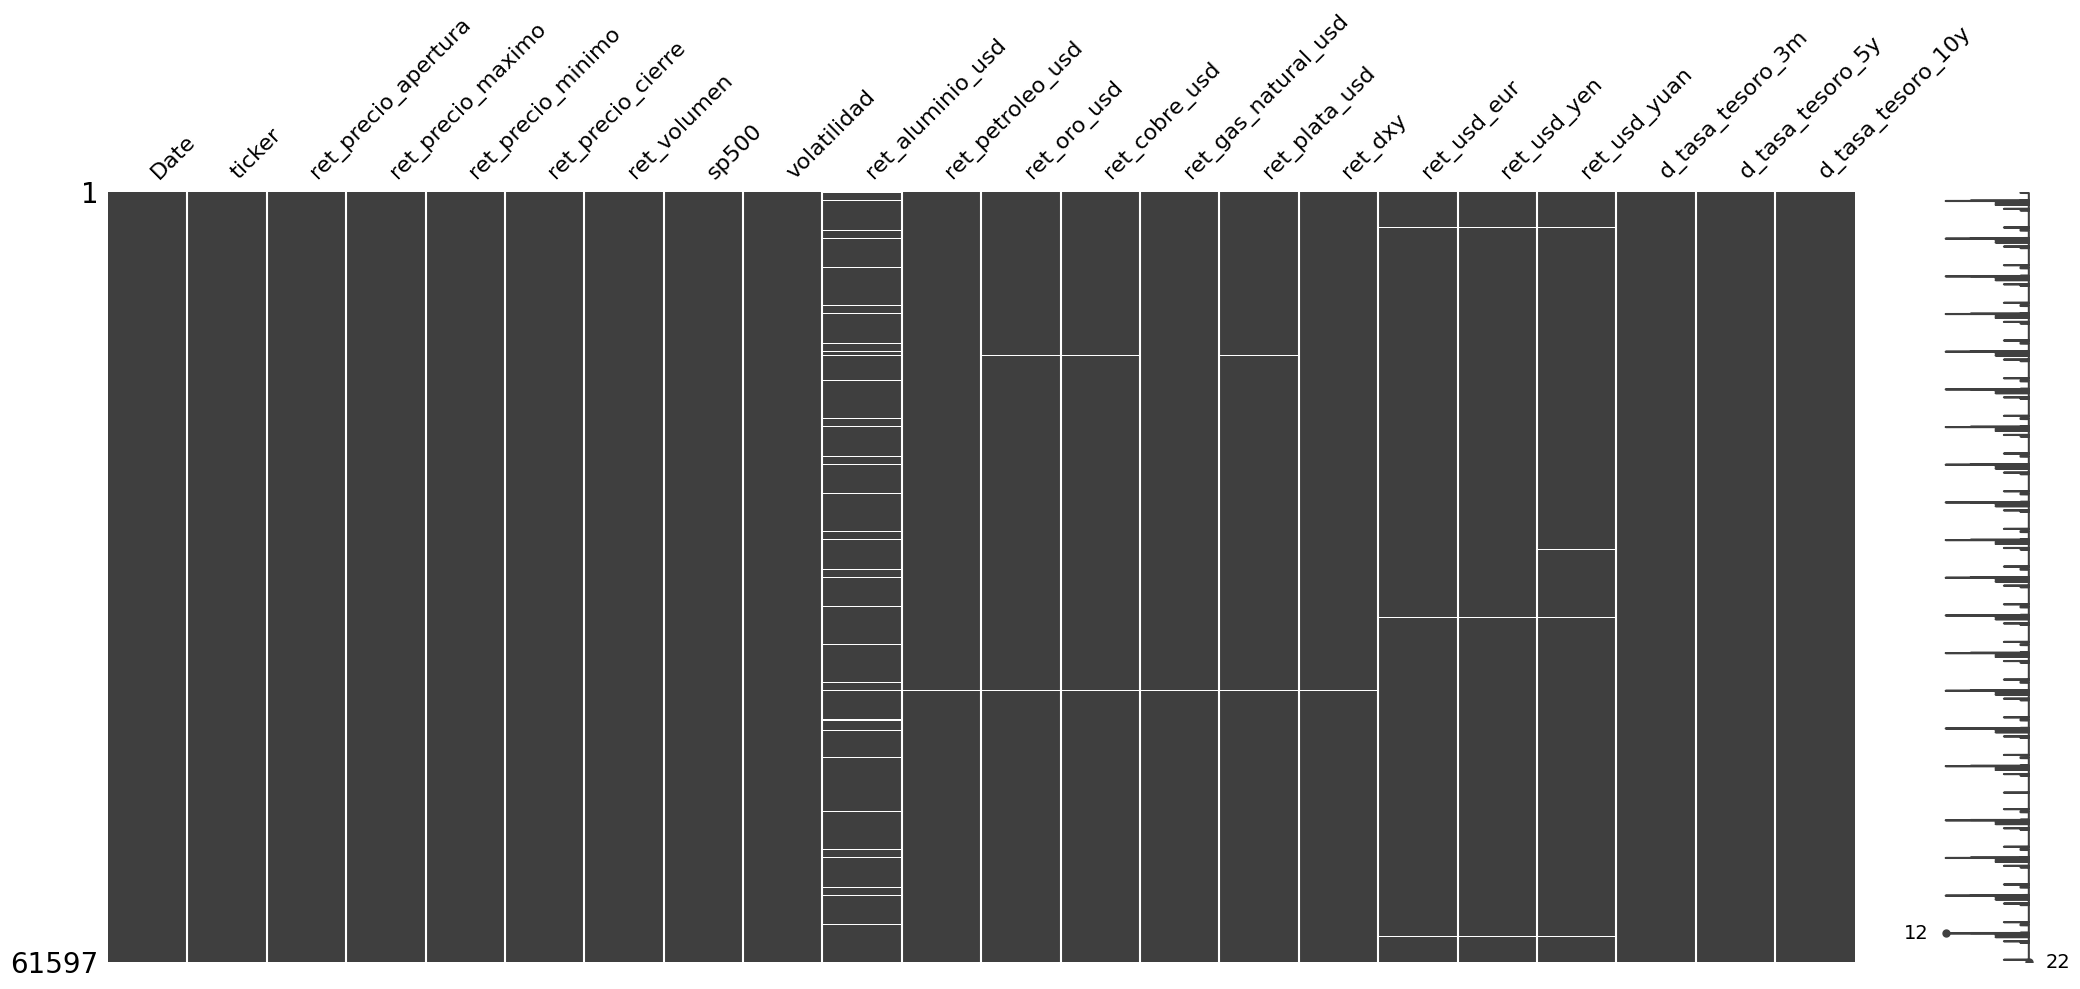

In [ ]:
msno.matrix(df)

## **6. Quitar la Columna Target**

In [ ]:
X = df.drop('ret_precio_cierre',axis=1)
y = df['ret_precio_cierre']

## **7. Rellenar NAN**

In [ ]:
df = df.sort_values(["ticker", "Date"])

In [ ]:
ret_macro = [
    c for c in df.columns
    if c.startswith("ret_")
    and "precio" not in c
    and c != "ret_precio_cierre"
]

df[ret_macro] = df[ret_macro].fillna(0)

In [ ]:
tasas_diff = [c for c in df.columns if c.startswith("d_tasa_")]
df[tasas_diff] = df[tasas_diff].fillna(0)

In [ ]:
df[["sp500", "volatilidad"]] = (
    df[["sp500", "volatilidad"]]
        .ffill()
        .bfill()
)

In [ ]:
df.isna().sum().sum()

np.int64(0)

<Axes: >

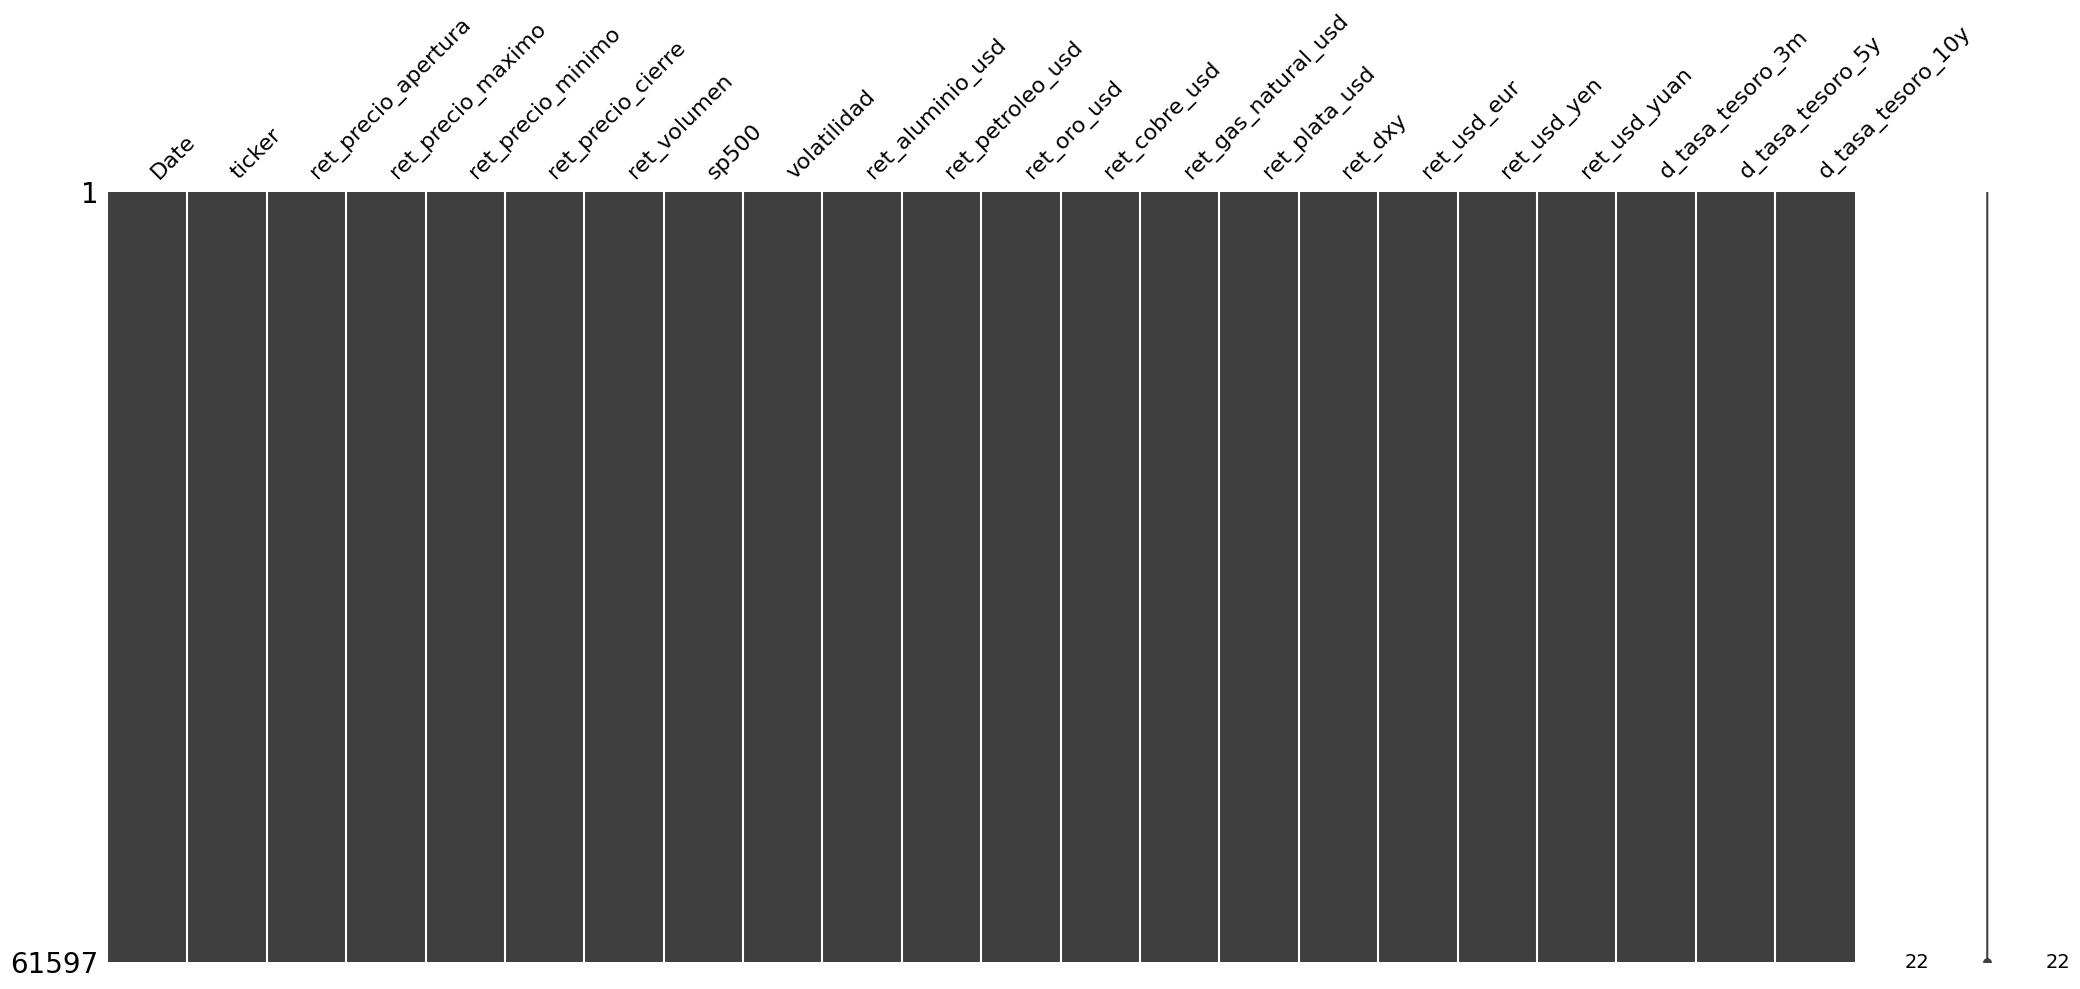

In [ ]:
msno.matrix(df)

## **8. Hacer Traint-Split**



In [ ]:
df["Date"] = pd.to_datetime(df["Date"])

In [ ]:
df = df.sort_values(["Date", "ticker"])

In [ ]:
split_date = pd.Timestamp("2022-01-01")

train_mask = df["Date"] < split_date
test_mask  = df["Date"] >= split_date

## **9. Categorización de Date y Tickers**

In [ ]:
df["t"] = df.groupby("ticker")["Date"] \
              .transform(lambda x: (x - x.min()).dt.days)
df["day_of_week"] = df["Date"].dt.dayofweek
dow_dummies = pd.get_dummies(
    df["day_of_week"],
    prefix="dow",
    drop_first=True
).astype(int)

df = pd.concat([df, dow_dummies], axis=1)
df.drop(columns=["day_of_week"], inplace=True)
df

,Date,ticker,ret_precio_apertura,ret_precio_maximo,ret_precio_minimo,ret_precio_cierre,ret_volumen,sp500,volatilidad,ret_aluminio_usd,...,ret_usd_yen,ret_usd_yuan,d_tasa_tesoro_3m,d_tasa_tesoro_5y,d_tasa_tesoro_10y,t,dow_1,dow_2,dow_3,dow_4
2,2014-01-07,AAPL,0.01,-0.01,-0.01,-0.01,0.05,-0.00,-0.02,0.00,...,0.01,-0.00,-0.00,-0.02,-0.02,0,1,0,0,0
3018,2014-01-07,AMZN,-0.00,-0.01,-0.02,0.01,0.36,-0.00,-0.02,0.00,...,0.01,-0.00,-0.00,-0.02,-0.02,0,1,0,0,0
6034,2014-01-07,CAT,-0.02,0.00,-0.01,0.00,0.34,-0.00,-0.02,0.00,...,0.01,-0.00,-0.00,-0.02,-0.02,0,1,0,0,0
9050,2014-01-07,CVX,-0.00,-0.00,-0.00,0.01,0.19,-0.00,-0.02,0.00,...,0.01,-0.00,-0.00,-0.02,-0.02,0,1,0,0,0
12066,2014-01-07,GOOGL,0.01,0.00,0.00,0.02,0.06,-0.00,-0.02,0.00,...,0.01,-0.00,-0.00,-0.02,-0.02,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49574,2025-12-30,PLTR,-0.01,-0.05,-0.03,-0.02,0.07,-0.00,0.04,0.02,...,0.00,0.00,0.00,0.00,0.01,1915,1,0,0,0
52590,2025-12-30,TSLA,-0.02,-0.04,-0.03,-0.01,0.12,-0.00,0.04,0.02,...,0.00,0.00,0.00,0.00,0.01,4375,1,0,0,0
55606,2025-12-30,UAA,0.07,0.02,0.00,0.08,0.37,-0.00,0.04,0.02,...,0.00,0.00,0.00,0.00,0.01,4375,1,0,0,0
58622,2025-12-30,VFC,-0.01,-0.01,-0.00,0.00,0.44,-0.00,0.04,0.02,...,0.00,0.00,0.00,0.00,0.01,4375,1,0,0,0


In [ ]:
df = pd.get_dummies(df, columns=["ticker"], prefix="ticker")
ticker_cols = [c for c in df.columns if c.startswith("ticker_")]
df[ticker_cols] = df[ticker_cols].astype(int)
df

,Date,ret_precio_apertura,ret_precio_maximo,ret_precio_minimo,ret_precio_cierre,ret_volumen,sp500,volatilidad,ret_aluminio_usd,ret_petroleo_usd,...,ticker_NFLX,ticker_NKE,ticker_NVDA,ticker_ORCL,ticker_PFE,ticker_PLTR,ticker_TSLA,ticker_UAA,ticker_VFC,ticker_XOM
2,2014-01-07,0.01,-0.01,-0.01,-0.01,0.05,-0.00,-0.02,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
3018,2014-01-07,-0.00,-0.01,-0.02,0.01,0.36,-0.00,-0.02,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
6034,2014-01-07,-0.02,0.00,-0.01,0.00,0.34,-0.00,-0.02,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
9050,2014-01-07,-0.00,-0.00,-0.00,0.01,0.19,-0.00,-0.02,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
12066,2014-01-07,0.01,0.00,0.00,0.02,0.06,-0.00,-0.02,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49574,2025-12-30,-0.01,-0.05,-0.03,-0.02,0.07,-0.00,0.04,0.02,-0.00,...,0,0,0,0,0,1,0,0,0,0
52590,2025-12-30,-0.02,-0.04,-0.03,-0.01,0.12,-0.00,0.04,0.02,-0.00,...,0,0,0,0,0,0,1,0,0,0
55606,2025-12-30,0.07,0.02,0.00,0.08,0.37,-0.00,0.04,0.02,-0.00,...,0,0,0,0,0,0,0,1,0,0
58622,2025-12-30,-0.01,-0.01,-0.00,0.00,0.44,-0.00,0.04,0.02,-0.00,...,0,0,0,0,0,0,0,0,1,0


## **10. Hacer Train-Split**

In [ ]:
X = df.drop(columns=["ret_precio_cierre", "Date"])
y = df["ret_precio_cierre"]

X_train = X[train_mask]
X_test  = X[test_mask]

y_train = y[train_mask]
y_test  = y[test_mask]

## **11. Outliers**

In [ ]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
ret_precio_apertura,40555.00,0.00,0.02,-0.25,-0.01,0.00,0.01,0.33
ret_precio_maximo,40555.00,0.00,0.02,-0.24,-0.01,0.00,0.01,0.24
ret_precio_minimo,40555.00,0.00,0.02,-0.28,-0.01,0.00,0.01,0.24
ret_volumen,40555.00,-0.00,0.35,-2.15,-0.22,-0.02,0.20,2.58
sp500,40555.00,0.00,0.01,-0.12,-0.00,0.00,0.01,0.09
volatilidad,40555.00,0.00,0.09,-0.26,-0.04,-0.00,0.04,1.16
ret_aluminio_usd,40555.00,0.00,0.01,-0.18,-0.00,0.00,0.00,0.04
ret_petroleo_usd,40555.00,-0.00,0.08,-3.06,-0.01,0.00,0.01,0.38
ret_oro_usd,40555.00,0.00,0.01,-0.05,-0.00,0.00,0.00,0.06
ret_cobre_usd,40555.00,0.00,0.01,-0.07,-0.01,0.00,0.01,0.07


In [ ]:
iso = IsolationForest(random_state=123)
df_num = X_train.copy()
df_num['outlier_flag'] = iso.fit_predict(X_train)

In [ ]:
df_num['outlier_flag'].value_counts()

,count
outlier_flag,
1,40392
-1,163


## **12. Selección de Características**

Método 1: Feature importance de RF

In [ ]:
# Entrenamiento de RF
model = RandomForestRegressor(random_state=42,n_jobs=-1).fit(X_train, y_train)

In [ ]:
# Importancia de características
importances = model.feature_importances_/model.feature_importances_.sum()*100

# Convertir a DataFrame
df_rf_imp = pd.DataFrame({'feature': X_train.columns,'rf_importance': importances}).sort_values(by='rf_importance', ascending=False)

# Calculamos la importancia acumulada
df_rf_imp['rf_importance_acum'] = df_rf_imp['rf_importance'].cumsum()

In [ ]:
df_rf_imp

,feature,rf_importance,rf_importance_acum
0,ret_precio_apertura,21.12,21.12
1,ret_precio_maximo,8.35,29.47
2,ret_precio_minimo,8.31,37.77
3,ret_volumen,5.36,43.13
4,sp500,4.96,48.09
7,ret_petroleo_usd,4.73,52.82
18,d_tasa_tesoro_10y,4.71,57.53
9,ret_cobre_usd,3.16,60.69
16,d_tasa_tesoro_3m,2.85,63.54
15,ret_usd_yuan,2.77,66.31


Método 2: Permutation/Shuffle importance

In [ ]:
# Para esta técnica y la de shap se necesita conjunto de validación
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Ajustamos el modelo
model_xgb = XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train1, y_train1)

In [ ]:
# Realizamos 10 permutaciones por cada característica
perm = permutation_importance(model_xgb, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1, scoring='neg_mean_absolute_error')

In [ ]:
df_perm_imp = pd.DataFrame({'feature': X_train.columns, 'perm_imp': perm.importances_mean*100}).sort_values('perm_imp', ascending=False)
df_perm_imp

,feature,perm_imp
0,ret_precio_apertura,0.35
18,d_tasa_tesoro_10y,0.18
17,d_tasa_tesoro_5y,0.11
4,sp500,0.08
1,ret_precio_maximo,0.08
2,ret_precio_minimo,0.07
7,ret_petroleo_usd,0.05
5,volatilidad,0.05
19,t,0.04
11,ret_plata_usd,0.04


Método 3: SHAP

In [ ]:
model_lgbm = lgb.LGBMRegressor(random_state=42, n_jobs=-1).fit(X_train1, y_train1)
explainer = shap.TreeExplainer(model_lgbm)
shap_vals = explainer.shap_values(X_val, check_additivity=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 32444, number of used features: 45
[LightGBM] [Info] Start training from score 0.000907


In [ ]:
imp_shap = np.abs(shap_vals).mean(axis=0)
imp_shap_pct = imp_shap/imp_shap.sum()*100
df_shap_imp = pd.DataFrame({"feature": X_val.columns, "shap_imp": imp_shap_pct}).sort_values('shap_imp', ascending=False)
df_shap_imp

,feature,shap_imp
0,ret_precio_apertura,24.26
18,d_tasa_tesoro_10y,10.89
4,sp500,8.32
7,ret_petroleo_usd,8.22
9,ret_cobre_usd,7.46
1,ret_precio_maximo,7.04
2,ret_precio_minimo,5.03
17,d_tasa_tesoro_5y,3.61
11,ret_plata_usd,3.34
8,ret_oro_usd,2.65


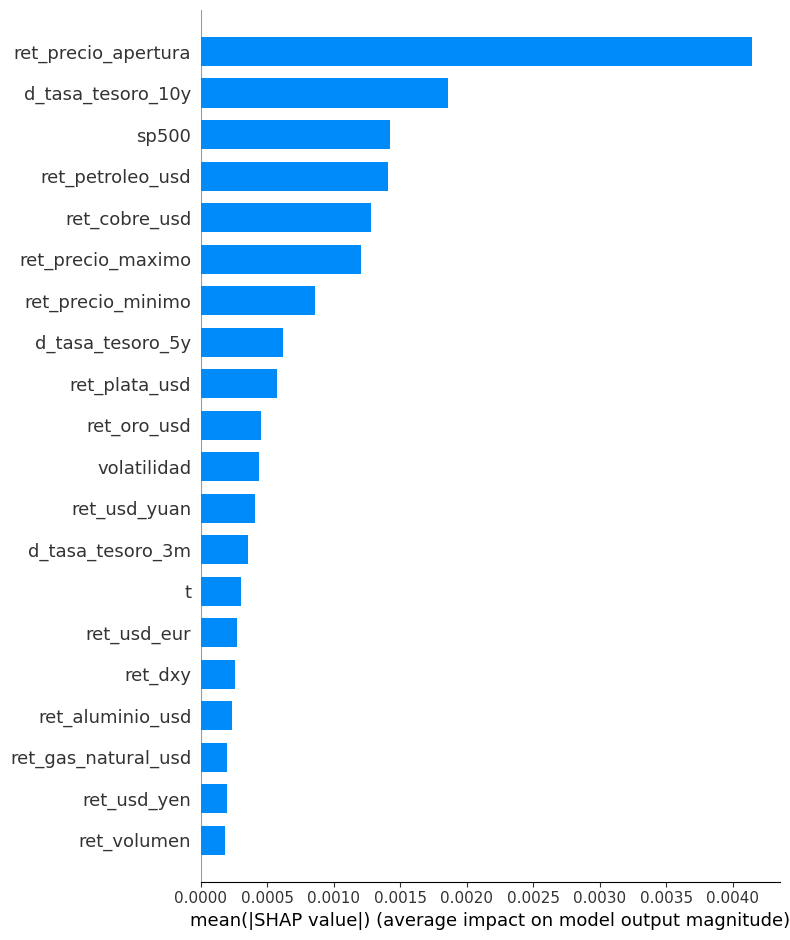

In [ ]:
# --- SHAP Summary Bar Plot ---
shap.summary_plot(shap_vals, X_val, plot_type="bar")

Unión 3 métodos

In [ ]:
df_importances = (
    df_rf_imp
    .merge(df_perm_imp, on='feature', how='outer')
    .merge(df_shap_imp, on='feature', how='outer')
).sort_values('rf_importance', ascending=False)
df_importances

,feature,rf_importance,rf_importance_acum,perm_imp,shap_imp
14,ret_precio_apertura,21.12,21.12,0.35,24.26
15,ret_precio_maximo,8.35,29.47,0.08,7.04
16,ret_precio_minimo,8.31,37.77,0.07,5.03
20,ret_volumen,5.36,43.13,0.00,1.05
21,sp500,4.96,48.09,0.08,8.32
12,ret_petroleo_usd,4.73,52.82,0.05,8.22
0,d_tasa_tesoro_10y,4.71,57.53,0.18,10.89
8,ret_cobre_usd,3.16,60.69,0.02,7.46
1,d_tasa_tesoro_3m,2.85,63.54,0.02,2.09
19,ret_usd_yuan,2.77,66.31,0.02,2.36


In [ ]:
df_filt = df_importances[(df_importances['rf_importance']>=1)|(df_importances['perm_imp']>=1)|(df_importances['shap_imp']>=1)]
df_filt

,feature,rf_importance,rf_importance_acum,perm_imp,shap_imp
14,ret_precio_apertura,21.12,21.12,0.35,24.26
15,ret_precio_maximo,8.35,29.47,0.08,7.04
16,ret_precio_minimo,8.31,37.77,0.07,5.03
20,ret_volumen,5.36,43.13,0.00,1.05
21,sp500,4.96,48.09,0.08,8.32
12,ret_petroleo_usd,4.73,52.82,0.05,8.22
0,d_tasa_tesoro_10y,4.71,57.53,0.18,10.89
8,ret_cobre_usd,3.16,60.69,0.02,7.46
1,d_tasa_tesoro_3m,2.85,63.54,0.02,2.09
19,ret_usd_yuan,2.77,66.31,0.02,2.36


## **13. Medir Correlación de Variables**

In [ ]:
features = df_filt['feature']
features

,feature
14,ret_precio_apertura
15,ret_precio_maximo
16,ret_precio_minimo
20,ret_volumen
21,sp500
12,ret_petroleo_usd
0,d_tasa_tesoro_10y
8,ret_cobre_usd
1,d_tasa_tesoro_3m
19,ret_usd_yuan


## **14. Quito d_tasa_tesoro_5y**

In [ ]:
new_features = features[features != 'd_tasa_tesoro_5y']
new_features

,feature
14,ret_precio_apertura
15,ret_precio_maximo
16,ret_precio_minimo
20,ret_volumen
21,sp500
12,ret_petroleo_usd
0,d_tasa_tesoro_10y
8,ret_cobre_usd
1,d_tasa_tesoro_3m
19,ret_usd_yuan


## **15. Dejo solo 10 variables**

In [ ]:
features_a_quitar = [
    'ret_dxy', 't', 'volatilidad','ret_oro_usd','ret_plata_usd',
    'ret_usd_yen','ret_gas_natural_usd','ret_usd_eur',
    'ret_aluminio_usd','ticker_TSLA', 'd_tasa_tesoro_5y'
]


new_features2 = [f for f in features if f not in features_a_quitar]
new_features2

['ret_precio_apertura',
 'ret_precio_maximo',
 'ret_precio_minimo',
 'ret_volumen',
 'sp500',
 'ret_petroleo_usd',
 'd_tasa_tesoro_10y',
 'ret_cobre_usd',
 'd_tasa_tesoro_3m',
 'ret_usd_yuan']

## **15. Hago calculo del VIF**

In [ ]:
from statsmodels.tools.tools import add_constant

X_vif = add_constant(X_train[features])

vif = pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],index=X_vif.columns)
vif = vif.drop("const")
vif

,0
ret_precio_apertura,1.22
ret_precio_maximo,3.10
ret_precio_minimo,3.19
ret_volumen,1.35
sp500,2.42
ret_petroleo_usd,1.04
d_tasa_tesoro_10y,8.42
ret_cobre_usd,1.36
d_tasa_tesoro_3m,1.07
ret_usd_yuan,1.10


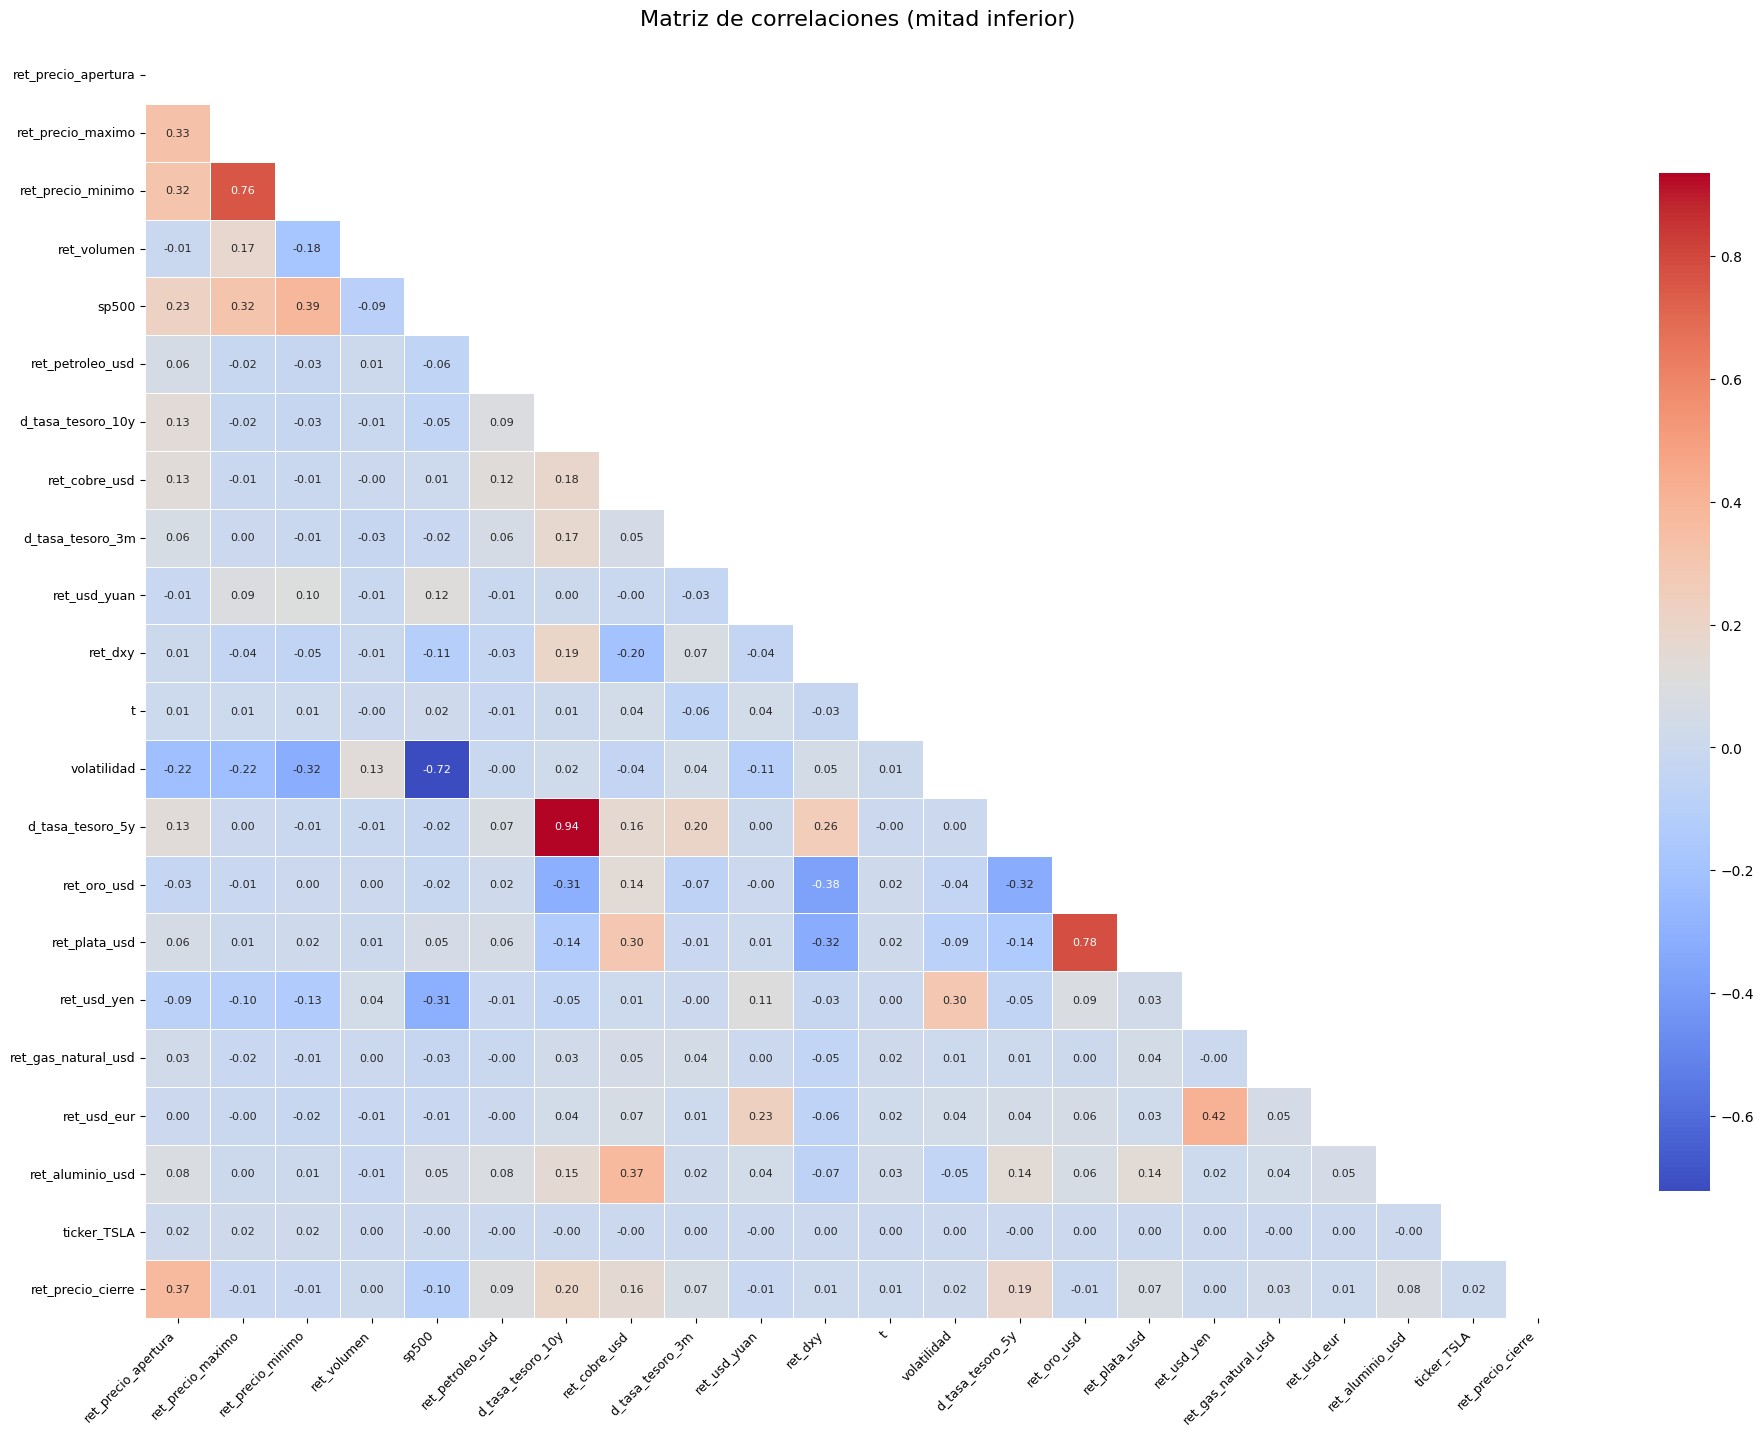

In [ ]:
X_copy = X_train[features].copy()
X_copy['ret_precio_cierre'] = y_train
corr = X_copy.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 15))
sns.heatmap(
    corr, mask=mask, cmap='coolwarm',
    annot=True, fmt=".2f", linewidths=.5,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 8}
)
plt.title("Matriz de correlaciones (mitad inferior)", fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout(pad=3.0)
plt.show()

## **16. Cross Validation**

In [ ]:
# Versión 1: Realizar cross_validation con todas las características que son candidatas
tscv = TimeSeriesSplit(n_splits=3)

cv_results1 = cross_val_score(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    X_train[features],
    y_train,
    cv=tscv,
    scoring='neg_mean_absolute_error'
)

In [ ]:
cv_results1.mean() * -1

np.float64(0.013348449334401694)

In [ ]:
# Versión 2: Realizar cross_validation con todas las características que son candidatas menos d_tasa_tesoro_5y. Debido a Valor Alto de VIF.
tscv = TimeSeriesSplit(n_splits=3)

cv_results2 = cross_val_score(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    X_train[new_features],
    y_train,
    cv=tscv,
    scoring='neg_mean_absolute_error'
)

In [ ]:
cv_results2.mean() * -1

np.float64(0.013385153210707755)

In [ ]:
# Versión 3: Realizar cross_validation con todas las características que son candidatas menos features_a_quitar. Para dejar solo 10 variables.
tscv = TimeSeriesSplit(n_splits=3)

cv_results3 = cross_val_score(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    X_train[new_features2],
    y_train,
    cv=tscv,
    scoring='neg_mean_absolute_error'
)

In [ ]:
cv_results3.mean() * -1

np.float64(0.013311962575005153)

## **17. Modelado con las Características Seleccionadas**

In [ ]:
# Selecciona la caracteristicas con las que hemos determinado que vamos a proseguir el análisis
X_train_sel = X_train[new_features2]
X_test_sel = X_test[new_features2]

In [ ]:
X_train_sel.describe().T

,count,mean,std,min,25%,50%,75%,max
ret_precio_apertura,40555.00,0.00,0.02,-0.25,-0.01,0.00,0.01,0.33
ret_precio_maximo,40555.00,0.00,0.02,-0.24,-0.01,0.00,0.01,0.24
ret_precio_minimo,40555.00,0.00,0.02,-0.28,-0.01,0.00,0.01,0.24
ret_volumen,40555.00,-0.00,0.35,-2.15,-0.22,-0.02,0.20,2.58
sp500,40555.00,0.00,0.01,-0.12,-0.00,0.00,0.01,0.09
ret_petroleo_usd,40555.00,-0.00,0.08,-3.06,-0.01,0.00,0.01,0.38
d_tasa_tesoro_10y,40555.00,-0.00,0.04,-0.22,-0.03,-0.00,0.03,0.27
ret_cobre_usd,40555.00,0.00,0.01,-0.07,-0.01,0.00,0.01,0.07
d_tasa_tesoro_3m,40555.00,-0.00,0.02,-0.24,-0.01,0.00,0.01,0.11
ret_usd_yuan,40555.00,-0.00,0.00,-0.02,-0.00,0.00,0.00,0.01


## **18. Gráfico de las Variables**

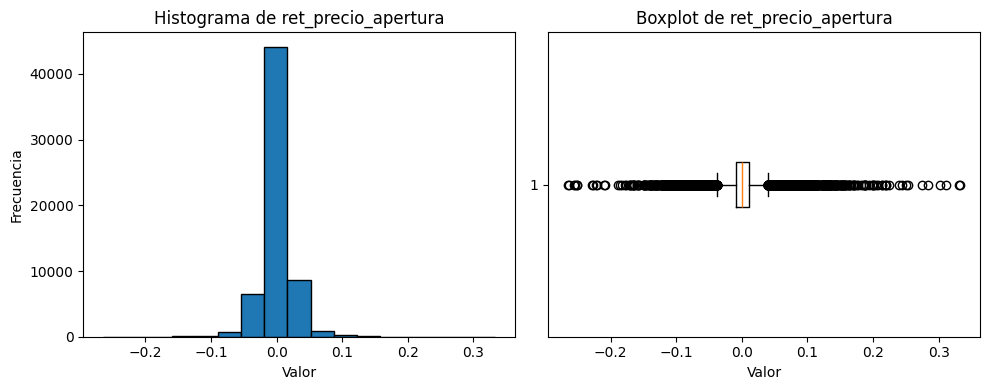

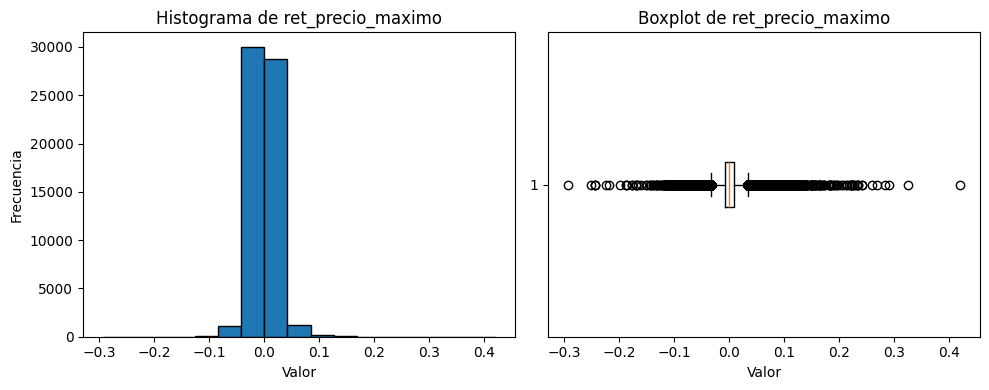

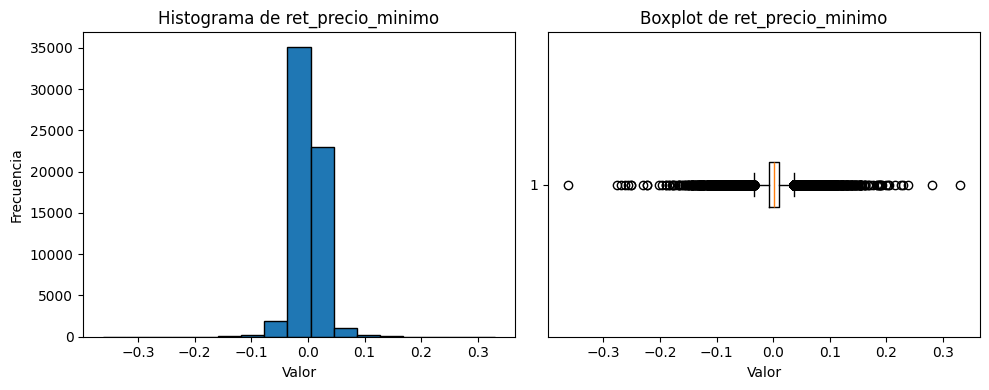

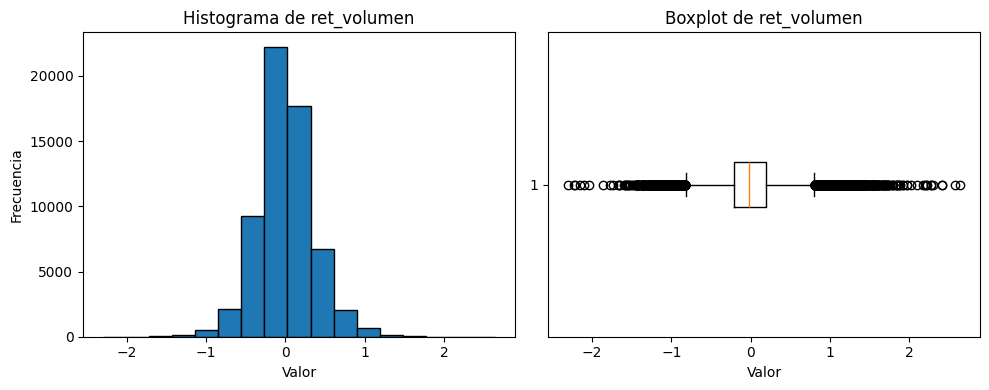

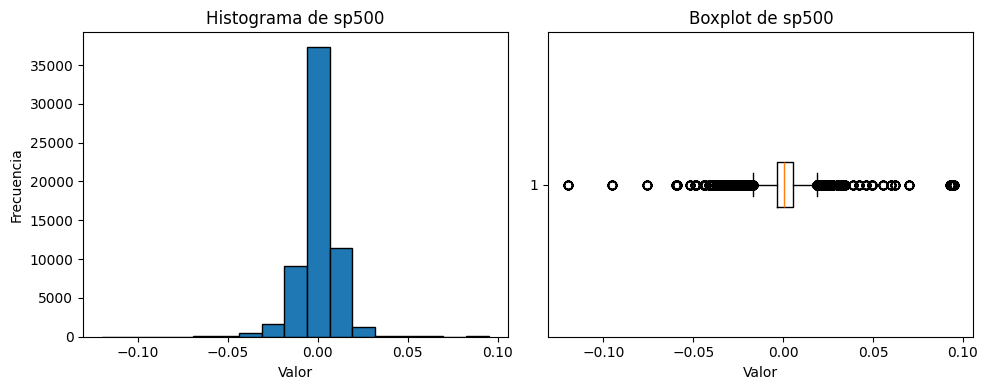

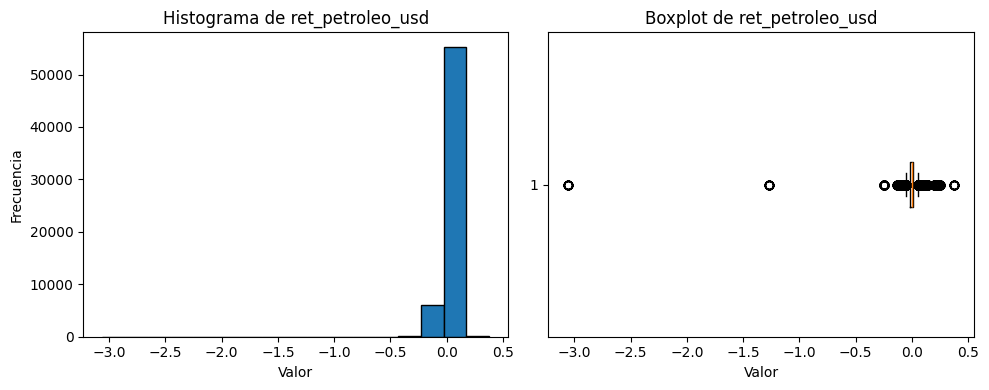

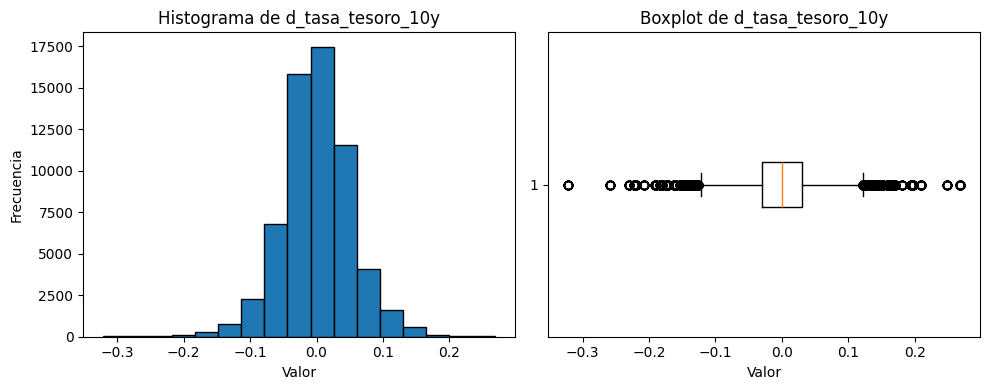

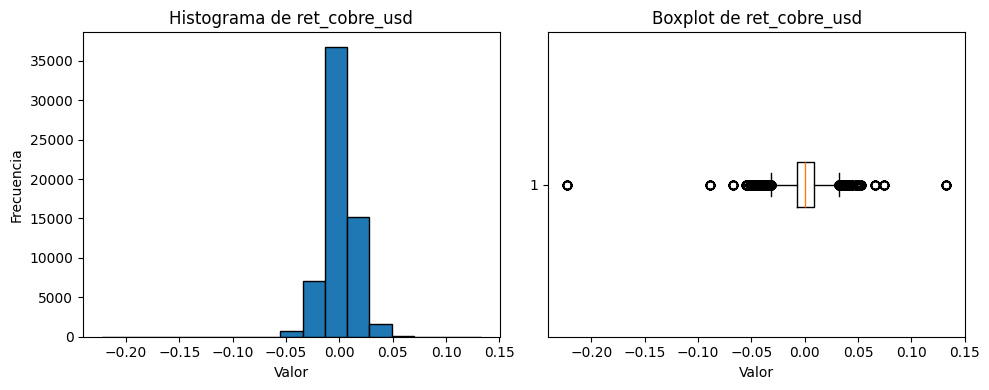

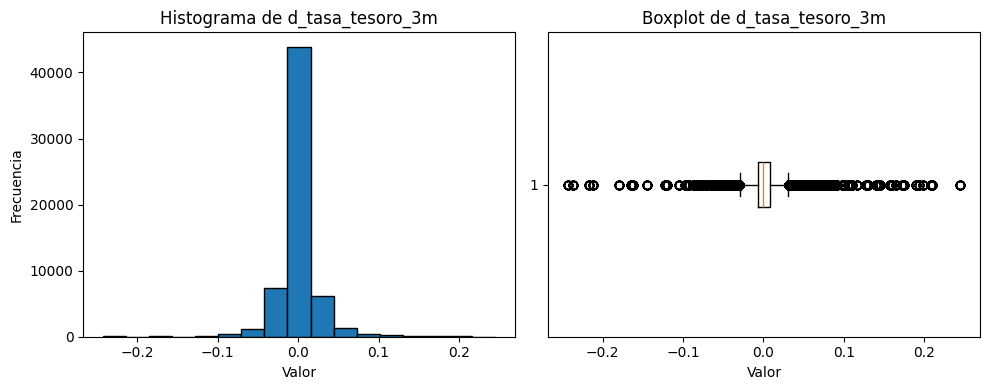

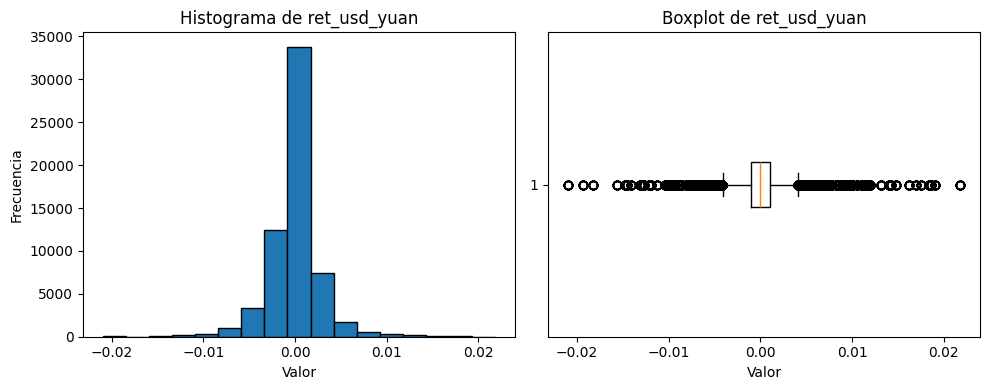

In [ ]:


for var in new_features2:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    ax[0].hist(df[var], bins="sturges", edgecolor="black")
    ax[0].set_title(f"Histograma de {var}")
    ax[0].set_xlabel("Valor")
    ax[0].set_ylabel("Frecuencia")

    ax[1].boxplot(df[var], vert=False)
    ax[1].set_title(f"Boxplot de {var}")
    ax[1].set_xlabel("Valor")

    plt.tight_layout()
    plt.show()

In [ ]:
y_train.skew()

np.float64(0.38236218200911526)

In [ ]:
y_train.describe()

,ret_precio_cierre
count,40555.00
mean,0.00
std,0.02
min,-0.26
25%,-0.01
50%,0.00
75%,0.01
max,0.30


## **19. Comparativa de Algoritmos**

In [ ]:
print("📊 Diagnóstico de X_train_sel")
diagnostico_X = pd.DataFrame({
    "NaN": X_train_sel.isna().sum(),
    "min": X_train_sel.min()
})
print(diagnostico_X)

print("\n📊 Diagnóstico de y_train")
print({
    "NaN": y_train.isna().sum(),
    "min": y_train.min()
})

📊 Diagnóstico de X_train_sel
                     NaN   min
ret_precio_apertura    0 -0.25
ret_precio_maximo      0 -0.24
ret_precio_minimo      0 -0.28
ret_volumen            0 -2.15
sp500                  0 -0.12
ret_petroleo_usd       0 -3.06
d_tasa_tesoro_10y      0 -0.22
ret_cobre_usd          0 -0.07
d_tasa_tesoro_3m       0 -0.24
ret_usd_yuan           0 -0.02

📊 Diagnóstico de y_train
{'NaN': np.int64(0), 'min': -0.25742918539935855}


In [ ]:
# Tenemos que obtener un conjunto de validación para validar la decisión de qué algoritmo elegir
X_train_sc1, X_val, y_train1, y_val = train_test_split(X_train_sel, y_train, test_size=0.2, random_state=42)

In [ ]:

import numpy as np
import pandas as pd

from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet,
    BayesianRidge, HuberRegressor, RANSACRegressor
)

from sklearn.neighbors import (
    KNeighborsRegressor, RadiusNeighborsRegressor
)
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    BaggingRegressor,
    HistGradientBoostingRegressor
)

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error
)

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "BayesianRidge": BayesianRidge(),
    "Huber": HuberRegressor(),
    "RANSAC": RANSACRegressor(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),

    "KNN_5": KNeighborsRegressor(n_neighbors=5),
    "KNN_10": KNeighborsRegressor(n_neighbors=10),
    "RadiusNN": RadiusNeighborsRegressor(radius=1.0),

    "SVR_RBF": SVR(kernel="rbf", C=1.0, epsilon=0.01),
    "SVR_Linear": LinearSVR(random_state=42),
    "RandomForest": RandomForestRegressor(
        random_state=42, n_jobs=-1
    ),

    "ExtraTrees": ExtraTreesRegressor(
        random_state=42, n_jobs=-1
    ),

    "GradientBoosting": GradientBoostingRegressor(
        random_state=42
    ),

    "AdaBoost": AdaBoostRegressor(
        random_state=42
    ),

    "Bagging_DT": BaggingRegressor(
        estimator=DecisionTreeRegressor(random_state=42),
        n_estimators=50,
        random_state=42,
        n_jobs=-1
    ),

    "HistGradientBoosting": HistGradientBoostingRegressor(
        random_state=42
    ),
    "LightGBM": LGBMRegressor(
        random_state=42
    ),
    "XGBoost": XGBRegressor(
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1
    ),

    "CatBoost": CatBoostRegressor(
        random_state=42,
        verbose=0
    )
}

results = []

for name, model in models.items():
    try:
        model.fit(X_train_sc1, y_train1)
        y_pred = model.predict(X_val)

        results.append({
            "model": name,
            "R2": r2_score(y_val, y_pred),
            "MAE": mean_absolute_error(y_val, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_val, y_pred))
        })

    except Exception as e:
        print(f"❌ {name} falló: {e}")
results_df = (
    pd.DataFrame(results)
    .sort_values("R2", ascending=False)
    .reset_index(drop=True)
)

results_df



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 32444, number of used features: 10
[LightGBM] [Info] Start training from score 0.000907


,model,R2,MAE,RMSE
0,CatBoost,0.40,0.01,0.02
1,RandomForest,0.39,0.01,0.02
2,Bagging_DT,0.39,0.01,0.02
3,ExtraTrees,0.38,0.01,0.02
4,LightGBM,0.38,0.01,0.02
5,XGBoost,0.37,0.01,0.02
6,HistGradientBoosting,0.36,0.01,0.02
7,GradientBoosting,0.29,0.01,0.02
8,SVR_RBF,0.26,0.01,0.02
9,BayesianRidge,0.21,0.01,0.02


## **20. Catboost**

In [ ]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function="RMSE",
    random_seed=42,
    verbose=0
)

cat.fit(X_train_sel, y_train)

In [ ]:
y_train_cat = cat.predict(X_train_sel)
y_test_cat = cat.predict(X_test_sel)

In [ ]:
r2_train = r2_score(y_train, y_train_cat)
r2_test  = r2_score(y_test, y_test_cat)
mae_test  = mean_absolute_error(y_test, y_test_cat)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_cat))


print(f"R2 TRAIN : {r2_train:.4f}")
print(f"R2 TEST  : {r2_test:.4f}")
print(f"MAE      : {mae_test:.6f}")
print(f"RMSE     : {rmse_test:.6f}")

R2 TRAIN : 0.4542
R2 TEST  : 0.1617
MAE      : 0.016378
RMSE     : 0.023847


## **23. Reducción de Overfiting de Catboost**

In [ ]:
from catboost import CatBoostRegressor

cat2 = CatBoostRegressor(
    iterations=800,
    learning_rate=0.03,
    depth=4,
    l2_leaf_reg=10,
    subsample=0.7,
    loss_function="RMSE",
    random_seed=42,
    verbose=0
)

cat2.fit(X_train_sel, y_train)

In [ ]:
y_train_cat2 = cat2.predict(X_train_sel)
y_test_cat2 = cat2.predict(X_test_sel)

In [ ]:
r2_train_op = r2_score(y_train, y_train_cat2)
r2_test_op  = r2_score(y_test, y_test_cat2)
mae_test_op  = mean_absolute_error(y_test, y_test_cat2)
rmse_test_op = np.sqrt(mean_squared_error(y_test, y_test_cat2))


print(f"R2 TRAIN : {r2_train_op:.4f}")
print(f"R2 TEST  : {r2_test_op:.4f}")
print(f"MAE      : {mae_test_op:.6f}")
print(f"RMSE     : {rmse_test_op:.6f}")

R2 TRAIN : 0.3699
R2 TEST  : 0.1636
MAE      : 0.016365
RMSE     : 0.023821


## **23. Optimizacion de Catboost**

In [ ]:

from scipy.stats import randint, uniform

param_dist = {
    "iterations": randint(300, 1200),
    "learning_rate": uniform(0.01, 0.05),
    "depth": randint(3, 6),
    "l2_leaf_reg": randint(5, 30),
    "subsample": uniform(0.6, 0.3)
}





In [ ]:
from catboost import CatBoostRegressor

cat_model_final = CatBoostRegressor(
    loss_function="RMSE",
    random_seed=42,
    verbose=0
)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=cat_model_final,
    param_distributions=param_dist,
    n_iter=15,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    verbose=3,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_sel, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x7af7f815d2e0>,
                   n_iter=15, n_jobs=-1,
                   param_distributions={'depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7af7fb6b1b80>,
                                        'iterations': <scipy.stats._distn_infrastructure.rv_discrete_frozen o...6b3170>,
                                        'l2_leaf_reg': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7af7f9c2e840>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7af7fb66e720>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7af7fb8111f0>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=3)

In [ ]:
best_cat = random_search.best_estimator_

print("Mejores hiperparámetros:")
print(random_search.best_params_)

Mejores hiperparámetros:
{'depth': 5, 'iterations': 727, 'l2_leaf_reg': 12, 'learning_rate': np.float64(0.01171942605576092), 'subsample': np.float64(0.8727961206236345)}


In [ ]:
y_train_pred = best_cat.predict(X_train_sel)
y_test_pred  = best_cat.predict(X_test_sel)

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

print("R2 TRAIN :", r2_score(y_train, y_train_pred))
print("R2 TEST  :", r2_score(y_test, y_test_pred))
print("MAE      :", mean_absolute_error(y_test, y_test_pred))
print("RMSE     :", np.sqrt(mean_squared_error(y_test, y_test_pred)))

R2 TRAIN : 0.316955987852531
R2 TEST  : 0.1633981439237222
MAE      : 0.01624454631659034
RMSE     : 0.023823885074860378


## **22. Guardar Modelo**

In [ ]:
import joblib

joblib.dump(
    {
        "model": best_cat,
        "features": X_train_sel.columns.tolist()
    },
    "modelo_rendimientos_catboost.pkl",
    compress=3
)

['modelo_rendimientos_catboost.pkl']